In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_5627/265554930.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 2. logistic regression

Derivative of the loss function:
$$
\frac{d L(\theta)}{d \theta} = \frac{1}{n} \sum_{i=1}^{n} (h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)} 
= \frac{1}{n}X_{\text{train}}^T  (\mathbf{y}_{\text{pred}} - \mathbf{y}_{\text{train}}) \in \mathbb{R}^{k+1}
$$

$x^{(i)}$ is the instance i from the data, 
$h_{\theta}(x^{(i)})$ is the predicted value of the instance $x^{(i)}$, 
$y^{(i)}$ is the actual value of the instance $x^{(i)}$

Our training set has $k$ features and $n$ instances

The derivative of the $i$-th component of the predictions vector is

$$ \cfrac{d {y}_{\text{pred}}^{(i)} }{d\theta} = \cfrac{d}{d\theta} \cfrac{1}{1+e^{\theta^T x^{(i)}}} = 
  \cfrac{1+e^{\theta^T x^{(i)}}}{( {{1+e^{\theta^T x^{(i)}}}})^2 } \cfrac{d ( \theta^T x^{(i)} ) }{d\theta} =
 {y}_{\text{pred}}^{(i)} ( 1 - {y}_{\text{pred}}^{(i)}) x^{(i)} \in \mathbb{R}^{k+1}$$

$$\text{So } \cfrac{d \mathbf{y_{\text{pred}}}}{d\theta} \in \mathbb{R}^{n, k+1} \text{ and}$$ 

$$
\cfrac{d \mathbf{y_{\text{pred}}}}{d\theta} = \begin{pmatrix} {y}_{\text{pred}}^{(1)} ( 1 - {y}_{\text{pred}}^{(1)}) x^{(1)}_1 & ... & {y}_{\text{pred}}^{(1)} ( 1 - {y}_{\text{pred}}^{(1)}) x^{(1)}_{k+1}  \\ \vdots \\  {y}_{\text{pred}}^{(i)} ( 1 - {y}_{\text{pred}}^{(i)}) x^{(n)}_1 & ... & {y}_{\text{pred}}^{(n)} ( 1 - {y}_{\text{pred}}^{(n)}) x^{(n)}_{k+1} \end{pmatrix} =
$$
$$
=
\begin{pmatrix} {y}_{\text{pred}}^{(1)} ( 1 - {y}_{\text{pred}}^{(1)}) & 0 & ... & 0 \\ \vdots \\  0 & 0 & ... & {y}_{\text{pred}}^{(n)} ( 1 - {y}_{\text{pred}}^{(n)}) {y}_{\text{pred}}^{(n)}  \end{pmatrix} \begin{pmatrix} x^{(1)}_1 & x^{(1)}_2 & ... & x^{(1)}_{k+1} \\ \vdots \\ x^{(n)}_1 & x^{(n)}_2 & ... & x^{(n)}_{k+1} \end{pmatrix} 
$$

$$
Finally,
\cfrac{d \mathbf{y_{\text{pred}}}}{d\theta} = \text{diag}({y}_{\text{pred}}^{(i)}  ( 1 - {y}_{\text{pred}}^{(i)})) X_{\text{train}} = D X_{\text{train}}
$$

$$
\text{ and } \text{Hessian} = \cfrac{1}{n} X_{\text{train}}^T  D X_{\text{train}}
$$


In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_logistic(test_data, coefficients):
    # adding a column of 1 to the left of x_train
    col_ones = np.ones((test_data.shape[0], 1))
    test_data = np.column_stack((col_ones, test_data))
    return sigmoid(np.dot(test_data, coefficients))

In [3]:
def loss_log(theta, x_train, y_train):
    n = len(y_train)
    y_pred = sigmoid(x_train @ theta)  # sigmoid ( (nx3) x (3x1))
    loss = -np.sum((y_train * np.log(y_pred) + (1 - y_train) * np.log(1 - y_pred))) / n
    return loss

def grad(theta, x_train, y_train):
    n = len(y_train)
    y_pred = sigmoid(x_train @ theta)
    grad = x_train.T @ (y_pred - y_train) / n
    return grad

def hessian(theta, x_train, y_train):
    n = len(y_train)
    y_pred = sigmoid(x_train @ theta)
    D = np.diag(y_pred * (1 - y_pred))
    hessian = x_train.T @ (D @ x_train) / n
    return hessian

In [4]:
def newtons_method(x_train, y_train, epsilon=1e-4):
    # adding a column of 1 to the left of x_train
    col_ones = np.ones((x_train.shape[0], 1))
    x_train = np.column_stack((col_ones, x_train))

    theta = np.zeros(x_train.shape[1])
    theta_old = np.ones(x_train.shape[1])
    iter = 0
    while np.linalg.norm(theta - theta_old, 2) > epsilon and iter <= 5000:
        theta_old = theta.copy()
        theta = theta - np.linalg.inv(hessian(theta, x_train, y_train)) @ grad(theta, x_train, y_train)
        iter += 1

    return theta

## set1

In [5]:
def standardize(data, test_data):
    """
    makes the data follow a standard normal
    
    params
    ------
    dataframes of train and test data 

    returns 
    -------
    np.ndarray, np.ndarray : standardized train data, standardized test data
    """
    data = data.to_numpy()
    test_data = test_data.to_numpy()

    mean = [] # means of each feature of the train set
    std = [] # standard deviations of each feature of the train set

    # for each column ( feature )
    for i in range(data.shape[1]):
        mean.append(np.mean(data[:,i])) # mean 
        std.append(np.std(data[:,i])) # std

    # standarize the matrices
    data = (data - mean)/std
    test_data = (test_data - mean)/std

    return data, test_data

In [6]:
data = pd.read_csv('set1_train.txt', sep='\s+', skiprows=1)
data.columns = ["x1", "x2", "y"]
y_train = data['y']
x_train = data.drop(["y"],axis=1)

data_test = pd.read_csv('set1_test.txt', sep='\s+', skiprows=1)
data_test.columns = ["x1", "x2", "y"]
y_test = data_test['y']
x_test = data_test.drop(["y"],axis=1)

In [7]:
x_train, x_test = standardize(x_train, x_test)

[]

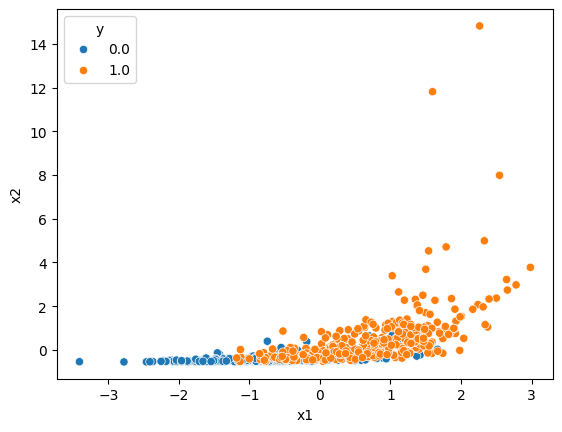

In [8]:
theta = newtons_method(x_train, y_train)
y_pred = predict_logistic(x_test, theta)
y_train_arr = y_train.to_numpy()
y_train_arr = y_train_arr.reshape(-1, 1)

columns = ['x1', 'x2', 'y']
standardized_data = pd.DataFrame(np.concatenate((x_train, y_train_arr),axis=1), columns= columns)
fig = sns.scatterplot(data=standardized_data, x="x1", y="x2", hue="y")
plt.plot()

In [9]:
print(x_train.shape)

(799, 2)


### i will compare them using F1 score

In [10]:
def f1score(conf_matrix):
    prec = precision(conf_matrix)
    rec = recall(conf_matrix)
    return 2* (prec * rec)/(prec + rec)

def precision(conf_matrix):
    return conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

def recall(conf_matrix):
    return conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])

### my logistic regression

the probabilities for each instance can be seen below

In [11]:
print(y_pred)

[0.55473575 0.30673569 0.6127524  0.21922166 0.34002525 0.18439581
 0.05563072 0.06419551 0.23673552 0.29160323 0.12587998 0.01573515
 0.08678952 0.42526249 0.08481828 0.05749815 0.20019943 0.99847726
 0.81624974 0.30981646 0.06004149 0.04850565 0.17860501 0.18618444
 0.80338397 0.34656926 0.12234948 0.24992669 0.0479761  0.03088461
 0.27003352 0.78071914 0.87970179 0.46729229 0.25246706 0.66049968
 0.10274695 0.04216759 0.18909438 0.10022545 0.70901019 0.83303547
 0.08369144 0.23339674 0.28596378 0.14367988 0.16224111 0.45819263
 0.34056088 0.73760402 0.97977358 0.18100102 0.94053384 0.99466224
 0.95946319 0.91348242 0.99749986 0.58242162 0.5188912  0.95094903
 0.76355198 0.94324389 0.99312066 0.98888351 0.48300054 0.99509784
 0.55063596 0.99910392 0.58248401 0.99287013 0.78776998 0.96020094
 0.99999992 0.99999999 0.13047346 0.99995188 0.25822384 0.51968999
 0.98682901 0.60205553 0.9999793  0.90343149 0.97590326 0.98420394
 0.90896671 0.99967011 0.33216625 0.58102945 0.57383348 0.3638

 My logistic regression F1 score = 0.8235294117647058


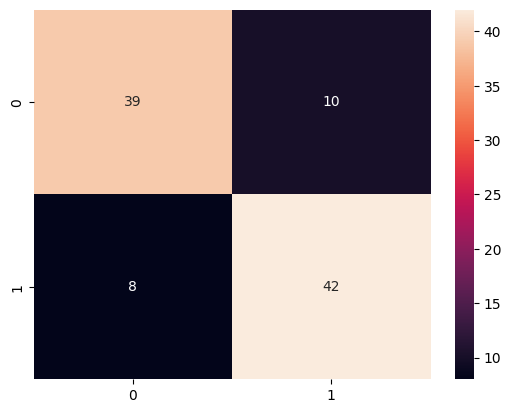

In [12]:
from sklearn.metrics import confusion_matrix

# change y_pred to 1 if prob >= 0.5 , else make it 0
y_pred = np.where(y_pred >= 0.5, 1, 0)

cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt='.0f')

print(f' My logistic regression F1 score = {f1score(cf)}')


### sklearn

 sklearn logistic regression F1 score = 0.8235294117647058


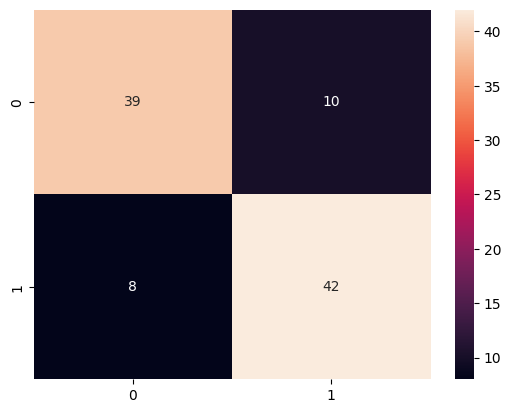

In [13]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt='.0f')

print(f' sklearn logistic regression F1 score = {f1score(cf)}')


$ z = \theta_0 + \theta_1 x_1 + \theta_2 x_2 $   is my logistic regression model

$\text{For }z = 0
\implies x_2 = - \frac{\theta_0}{\theta_2}  + \frac{\theta_1}{\theta_2}x_1$

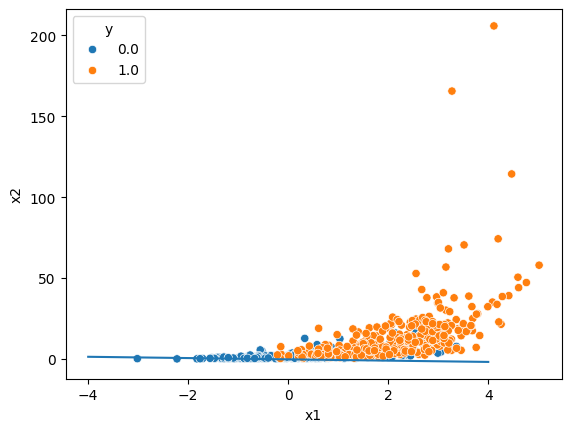

In [14]:
x = np.linspace(-4,4, 100)
y = lambda x: - theta[0]/theta[2] - theta[1]/theta[2] * x

fig = sns.scatterplot(data=data, x="x1", y="x2", hue="y")
plt.plot()
plt.plot(x, y(x))
plt.show()


to make the decision boundary more clear, i will filter some data to "zoom in"

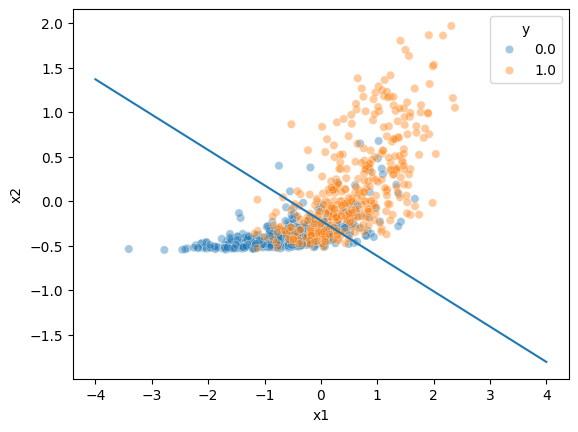

In [15]:
filtered = standardized_data[standardized_data['x2'] <= 2]
fig = sns.scatterplot(data=filtered, x="x1", y="x2", hue="y", alpha=.4)
plt.plot()
plt.plot(x, y(x))
plt.show()

## set2

[]

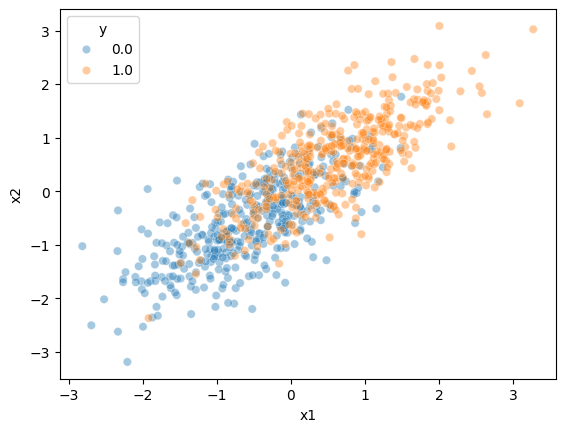

In [16]:
# load

data = pd.read_csv('set2_train.txt', sep='\s+', skiprows=1)
data.columns = ["x1", "x2", "y"]
y_train = data['y']
x_train = data.drop(["y"],axis=1)

data_test = pd.read_csv('set2_test.txt', sep='\s+', skiprows=1)
data_test.columns = ["x1", "x2", "y"]
y_test = data_test['y']
x_test = data_test.drop(["y"],axis=1)

# standardize
x_train, x_test = standardize(x_train, x_test)

# newton's method
theta = newtons_method(x_train, y_train)
y_pred = predict_logistic(x_test, theta)
y_train_arr = y_train.to_numpy()
y_train_arr = y_train_arr.reshape(-1, 1)

columns = ['x1', 'x2', 'y']
standardized_data = pd.DataFrame(np.concatenate((x_train, y_train_arr),axis=1), columns= columns)
fig = sns.scatterplot(data=standardized_data, x="x1", y="x2", hue="y", alpha=.4)
plt.plot()

In [17]:
print(y_pred)

#probabilities

[0.5460383  0.05175291 0.01711795 0.12663684 0.26476916 0.62736525
 0.1365847  0.53350444 0.15922497 0.8663155  0.07609212 0.08447943
 0.06676805 0.38080053 0.022018   0.43079774 0.00934278 0.05542795
 0.71705894 0.01188518 0.3672854  0.58349321 0.44928982 0.42000069
 0.00871731 0.01143091 0.32223042 0.02431144 0.15707398 0.09470033
 0.06009805 0.25247556 0.27597976 0.12797606 0.07039773 0.57040201
 0.74649283 0.0343977  0.68770137 0.37115169 0.42712817 0.11838904
 0.06562709 0.85329907 0.57892536 0.13641146 0.07325599 0.54767493
 0.72862415 0.87086412 0.64311207 0.14530604 0.72533935 0.6665325
 0.88034829 0.36571145 0.30755997 0.8725886  0.47823172 0.95726406
 0.95898132 0.90408733 0.52745221 0.86674813 0.96334834 0.67198746
 0.72494696 0.97478026 0.71954324 0.44790407 0.93541826 0.71741142
 0.84547088 0.89308696 0.64448406 0.45855663 0.5351208  0.92751536
 0.8890331  0.77112281 0.73670324 0.91613146 0.85132032 0.74049936
 0.85281532 0.98440908 0.64049509 0.09681413 0.75103981 0.61301

 My logistic regression F1 score = 0.7884615384615384


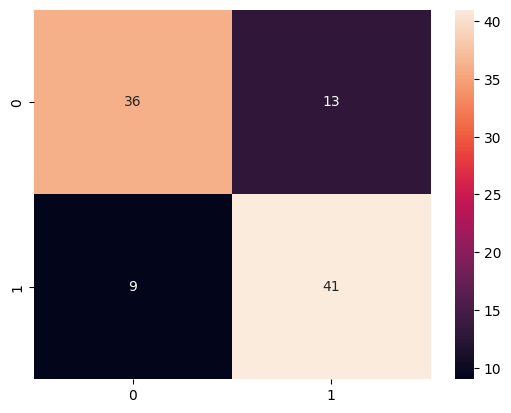

In [18]:
# change y_pred to 1 if prob >= 0.5 , else make it 0
y_pred = np.where(y_pred >= 0.5, 1, 0)

cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt='.0f')

print(f' My logistic regression F1 score = {f1score(cf)}')

 sklearn logistic regression F1 score = 0.7884615384615384


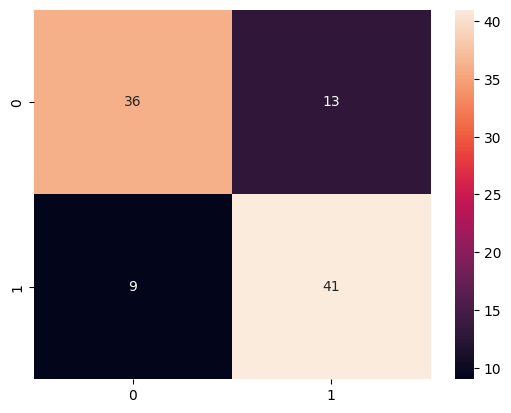

In [19]:

lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt='.0f')

print(f' sklearn logistic regression F1 score = {f1score(cf)}')

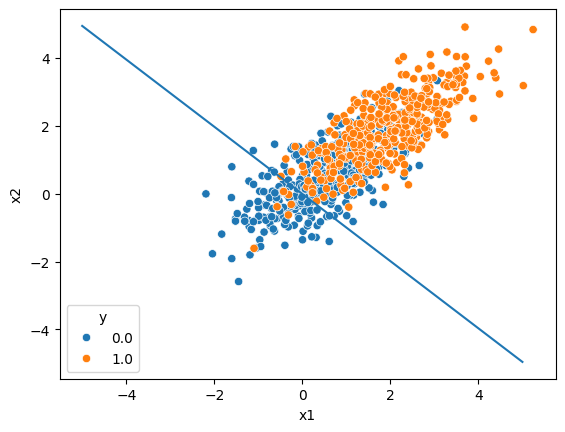

In [20]:
x = np.linspace(-5,5, 100)
y = lambda x: - theta[0]/theta[2] - theta[1]/theta[2] * x

fig = sns.scatterplot(data=data, x="x1", y="x2", hue="y")
plt.plot()
plt.plot(x, y(x))
plt.show()
